# Netflix Visualizations and Analysis

用csv檔案進入分析netflix數據，我會使用兩種方式數據分析，第一種是使用python 分析製圖，第二種是實作將資料存在mysql 轉成tableau 分析製圖。<br>
兩者的結果會一樣，但要練習用不同方法呈現。
<br>
Let's dive into code.
<br>
### Libraries

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly as ply
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from os import path
from PIL import Image
from wordcloud import WordCloud

### loading Dataset

In [267]:
netflix = pd.read_csv("./netflix_titles.csv")
netflix.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
1704,s1705,Movie,The Beginning of Life 2: Outside,Renata Terra,NaN,Brazil,"November 13, 2020",2020,TV-PG,92 min,"Documentaries, International Movies","As urbanization expands throughout society, th..."
5590,s5591,Movie,I Don't Feel at Home in This World Anymore,Macon Blair,"Melanie Lynskey, Elijah Wood, David Yow, Jane ...",United States,"February 24, 2017",2017,TV-MA,97 min,"Dramas, Independent Movies, Thrillers",A timid nursing assistant gets a new lease on ...
514,s515,TV Show,Cuckoo,NaN,"Andy Samberg, Taylor Lautner, Greg Davies, Hel...",United Kingdom,"July 6, 2021",2019,TV-MA,5 Seasons,"British TV Shows, International TV Shows, TV C...",Rachel shocks her proper British parents when ...
8645,s8646,Movie,Twinsanity,Buz Wallick,"Karissa Strain, Katie Strain, Yves Bright, Ang...",United States,"March 15, 2019",2018,TV-MA,86 min,"Horror Movies, Independent Movies, Thrillers",When a yoga enthusiast begins to pull away fro...
6123,s6124,Movie,Along Came a Spider,Lee Tamahori,"Morgan Freeman, Monica Potter, Michael Wincott...","United States, Germany, Canada","October 1, 2019",2001,R,103 min,Thrillers,When a girl is kidnapped from a prestigious pr...


In [268]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


### Visualization 

#### 電影和TV系列的分布(Movies and TV series distribution)

<bound method IndexOpsMixin.value_counts of 0         Movie
1       TV Show
2       TV Show
3       TV Show
4       TV Show
         ...   
8802      Movie
8803    TV Show
8804      Movie
8805      Movie
8806      Movie
Name: type, Length: 8807, dtype: object>


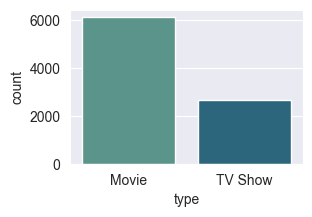

In [269]:
plt.figure(figsize=(3,2))
sns.countplot(data=netflix,x='type',palette='crest')
print(netflix['type'].value_counts)

#### 哪些國家有最多的shows? (Countries with most show?)
先使用pandas fillna 用 Uunknown 取代 nan (空值)，可以看到第三列的導演跟主演都是NaN 空值，但是他的country原本是空值，卻被換成Unknown。<br>
將country 是字串的的用逗號(",")切割字串,eg:Spain, Germany, Denmark, United States<br>
explode('country'):Turn every element in the "country" column into a row, some value in country has more than one country<br>
.strip() 沒有參數時，他從一個字符串中刪除任何開頭\結尾的空白。

In [270]:
netflix['country'].fillna('Unknown',inplace=True)
netflix.iloc[3]

show_id                                                        s4
type                                                      TV Show
title                                       Jailbirds New Orleans
director                                                      NaN
cast                                                          NaN
country                                                   Unknown
date_added                                     September 24, 2021
release_year                                                 2021
rating                                                      TV-MA
duration                                                 1 Season
listed_in                                  Docuseries, Reality TV
description     Feuds, flirtations and toilet talk go down amo...
Name: 3, dtype: object

In [271]:
netflix['country'] = netflix['country'].str.split(',')
country = netflix.explode('country')
country['country'] = country['country'].apply(lambda x: x.strip())

country_count = pd.DataFrame(country.groupby(['country'])['show_id'].count().sort_values(ascending=False))

country_count.drop(['Unknown'],inplace=True)

country_count.rename(columns={'show_id':'num_of_shows'},inplace=True)

country_count['百分比'] = country_count['num_of_shows'].apply(lambda x: (x/8807)*100)
country_count.head(5)



,num_of_shows,百分比
country,,
United States,3690,41.898490
India,1046,11.876916
United Kingdom,806,9.151811
Canada,445,5.052799
France,393,4.462359


有41.8% 的戲劇在美果出現，第二是印度11.8%，第三是英國

##### 全球分布圖
在分區統計圖(choropleth)中，data_frame 的每一行都由地圖上的彩色區域標記表示。

In [272]:
fig = px.choropleth(country_count,locations=country_count.index,locationmode='country names',color= 'num_of_shows')
fig.show()

#### Netflix 哪一種類型最受歡迎? which genre populate netflix the most?

In [273]:
netflix['listed_in'] = netflix['listed_in'].str.split(',')
genre = netflix.explode('listed_in')
genre['listed_in'] = genre['listed_in'].apply(lambda x: x.strip())

genre_count = pd.DataFrame(genre.groupby(['listed_in'])['show_id'].count().sort_values(ascending=False))


genre_count.rename(columns={'show_id':'num_of_shows'},inplace=True)

genre_count['百分比'] = genre_count['num_of_shows'].apply(lambda x: (x/8807)*100)

genre_count.head(5)


,num_of_shows,百分比
listed_in,,
International Movies,2752,31.247871
Dramas,2427,27.557625
Comedies,1674,19.007608
International TV Shows,1351,15.340070
Documentaries,869,9.867151


**最受歡迎的種類是**國際電影(international movies)占最高比重31.2%，第二是戲劇(dramas)27.5%,第三是喜劇(comedies)，這三種類在Netflix當中占78%。

<Axes: xlabel='num_of_shows', ylabel='listed_in'>

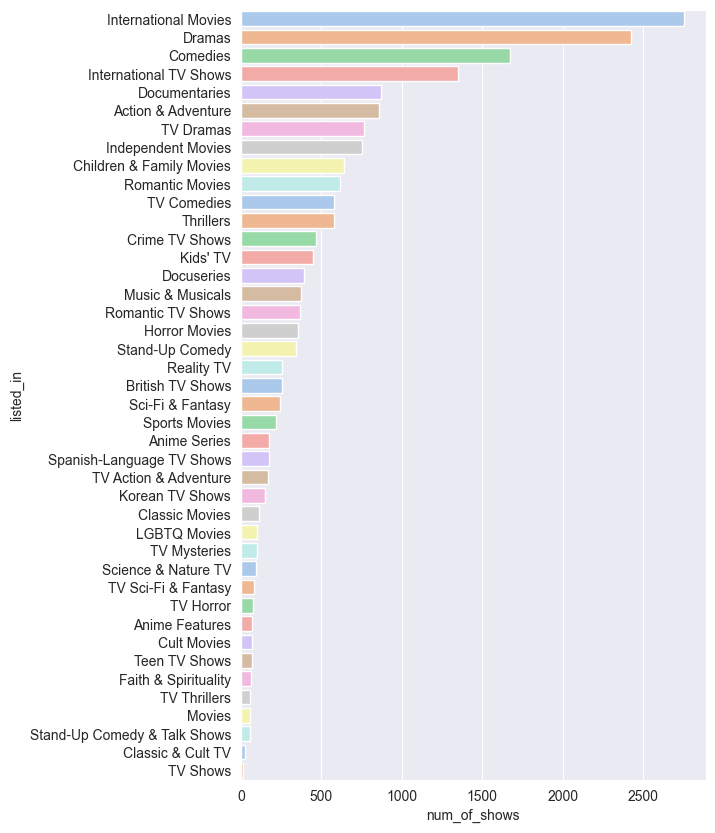

In [274]:
plt.figure(figsize=(6,10))
sns.set_style('darkgrid')
sns.barplot(data=genre_count,y=genre_count.index,x='num_of_shows',palette='pastel')


#### 哪一個是最長運行的TV show? which is the longest running tv show?
index.unique():從索引(列)返回唯一值，最終輸出是一個陣列。

In [275]:
netflix['duration'].unique()

array(['90 min', '2 Seasons', '1 Season', '91 min', '125 min',
       '9 Seasons', '104 min', '127 min', '4 Seasons', '67 min', '94 min',
       '5 Seasons', '161 min', '61 min', '166 min', '147 min', '103 min',
       '97 min', '106 min', '111 min', '3 Seasons', '110 min', '105 min',
       '96 min', '124 min', '116 min', '98 min', '23 min', '115 min',
       '122 min', '99 min', '88 min', '100 min', '6 Seasons', '102 min',
       '93 min', '95 min', '85 min', '83 min', '113 min', '13 min',
       '182 min', '48 min', '145 min', '87 min', '92 min', '80 min',
       '117 min', '128 min', '119 min', '143 min', '114 min', '118 min',
       '108 min', '63 min', '121 min', '142 min', '154 min', '120 min',
       '82 min', '109 min', '101 min', '86 min', '229 min', '76 min',
       '89 min', '156 min', '112 min', '107 min', '129 min', '135 min',
       '136 min', '165 min', '150 min', '133 min', '70 min', '84 min',
       '140 min', '78 min', '7 Seasons', '64 min', '59 min', '139 min',
    

這些被定義在Seasons 或season 的duration value 是TV shows. 反之，這些"不"被定義在Seasons 的duration value 是Movies. <br>
contains 方法用於判斷指定系列是否包含指定字符串。類似於SQL中的like函數。<br>
str 將series 轉換為類似於string的結構。返回布爾值或索引，具體取決於給定模式或正規表達式是否包含在系列或索引的字符串中。<br>
當regex 設置為true時，確保pat 不是文字模式。

In [276]:
netflix[netflix['duration'].str.contains('Seasons|Season',regex=True)==True]['type'].unique()

array(['TV Show'], dtype=object)

In [277]:
netflix[netflix['duration'].str.contains('Seasons|Season',regex=True)==False]['type'].unique()

array(['Movie'], dtype=object)

In [278]:
shows = netflix[netflix['type']=='TV Show']
shows.sample(5)
shows['duration'].unique()

array(['2 Seasons', '1 Season', '9 Seasons', '4 Seasons', '5 Seasons',
       '3 Seasons', '6 Seasons', '7 Seasons', '10 Seasons', '8 Seasons',
       '17 Seasons', '13 Seasons', '15 Seasons', '12 Seasons',
       '11 Seasons'], dtype=object)

<Axes: xlabel='count', ylabel='duration'>

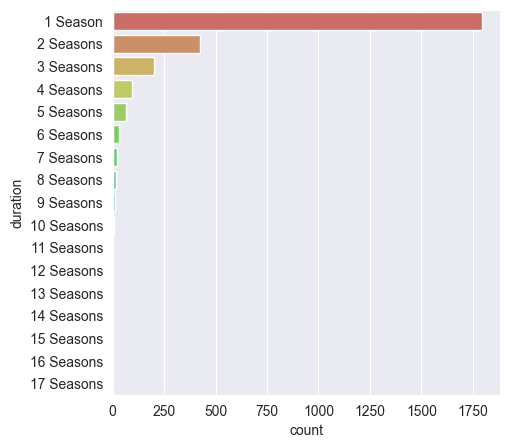

In [279]:
order = ['1 Season', '2 Seasons', '3 Seasons', '4 Seasons', '5 Seasons', '6 Seasons', '7 Seasons', '8 Seasons', '9 Seasons', '10 Seasons', '11 Seasons', '12 Seasons', '13 Seasons', '14 Seasons', '15 Seasons', '16 Seasons', '17 Seasons', ]
sns.set_style('darkgrid')
plt.figure(figsize=(5,5))
sns.countplot(data=shows,y='duration',palette='hls',order=order)


In [280]:
shows.groupby('duration')['show_id'].count().sort_values(ascending=False)

duration
1 Season      1793
2 Seasons      425
3 Seasons      199
4 Seasons       95
5 Seasons       65
6 Seasons       33
7 Seasons       23
8 Seasons       17
9 Seasons        9
10 Seasons       7
13 Seasons       3
11 Seasons       2
12 Seasons       2
15 Seasons       2
17 Seasons       1
Name: show_id, dtype: int64

In [281]:
shows['title'][shows['duration']=='17 Seasons']

548    Grey's Anatomy
Name: title, dtype: object

#### 在Netflix 最長的電影? Longest movie on Netflix?

dropna(inplace=true)過濾數據當中的空值(NaN)數據，inplace=true 覆蓋原來數據。
(\d+) regular express 一個或多個數字<br>

<Axes: xlabel='duration', ylabel='Count'>

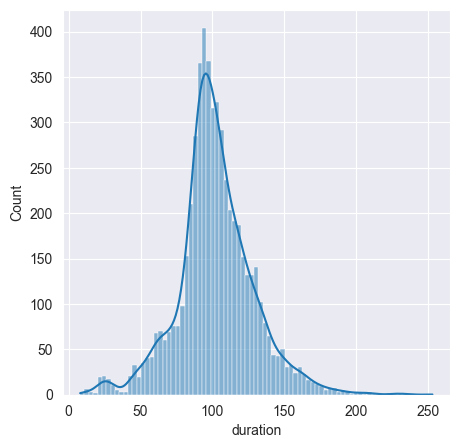

In [282]:
movies = netflix[netflix['type']=='Movie']
movies.dropna(inplace=True)
movies.duration = movies.duration.str.extract('(\d+)').astype('int32')

plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.histplot(data=movies,x='duration',kde=True)


差不多90-120min 的電影讓頭疼，比電視劇短。

In [283]:
movies[movies['duration']==movies['duration'].max()]['title']

2491    The School of Mischief
Name: title, dtype: object

A 1973 movie. I don't want to watch it either way.....

#### Netflix 適合你的小孩嗎? is Netflix suitable for your kids?

In [284]:
netflix['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', '74 min', '84 min', '66 min', 'NR', nan,
       'TV-Y7-FV', 'UR'], dtype=object)

In [285]:
netflix[netflix['rating'].str.contains("74 min|84 min|66min",regex=True)==True]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,[United States],"April 4, 2017",2017,74 min,NaN,[Movies],"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,[United States],"September 16, 2016",2010,84 min,NaN,[Movies],Emmy-winning comedy writer Louis C.K. brings h...


netflix['rating'].isna()會顯示"is NaN" = True，也就是空值為True。<br>
.tolist()會得到bool list

In [286]:
netflix['rating'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
8802    False
8803    False
8804    False
8805    False
8806    False
Name: rating, Length: 8807, dtype: bool

顯示rating是空值的表格

In [287]:
netflix[netflix['rating'].isna()]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5989,s5990,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"Oprah Winfrey, Ava DuVernay",[Unknown],"January 26, 2017",2017,NaN,37 min,[Movies],Oprah Winfrey sits down with director Ava DuVe...
6827,s6828,TV Show,Gargantia on the Verdurous Planet,NaN,"Kaito Ishikawa, Hisako Kanemoto, Ai Kayano, Ka...",[Japan],"December 1, 2016",2013,NaN,1 Season,"[Anime Series, International TV Shows]","After falling through a wormhole, a space-dwel..."
7312,s7313,TV Show,Little Lunch,NaN,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",[Australia],"February 1, 2018",2015,NaN,1 Season,"[Kids' TV, TV Comedies]","Adopting a child's perspective, this show take..."
7537,s7538,Movie,My Honor Was Loyalty,Alessandro Pepe,"Leone Frisa, Paolo Vaccarino, Francesco Miglio...",[Italy],"March 1, 2017",2015,NaN,115 min,[Dramas],"Amid the chaos and horror of World War II, a c..."


In [288]:
index = [5541, 5794, 5813,5989,6827,7312,7537]
rating = netflix.drop(axis=0,index=index) 

In [289]:
rating['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', 'NR', 'TV-Y7-FV', 'UR'], dtype=object)

得到一個乾淨的rating list

In [290]:
rating_count = pd.DataFrame(rating.groupby('rating')['show_id'].count().sort_values(ascending = False))

# rating.groupby('rating')['show_id'].count().sort_values(ascending = False)

rating_count.rename(columns={'show_id':'num_of_shows'},inplace=True)

rating_count['百分比'] = rating_count['num_of_shows'].apply(lambda x: (x/8807)*100)

rating_count.head(5)



,num_of_shows,百分比
rating,,
TV-MA,3207,36.414216
TV-14,2160,24.525945
TV-PG,863,9.799024
R,799,9.072329
PG-13,490,5.563756


<Axes: xlabel='count', ylabel='rating'>

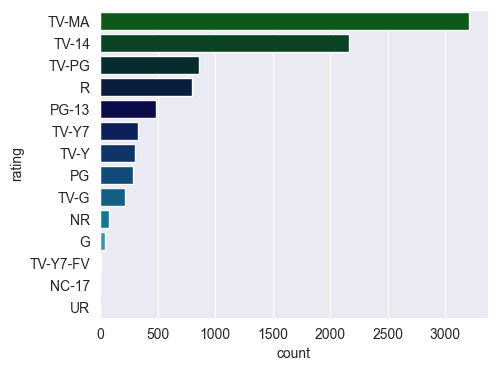

In [291]:
plt.figure(figsize=(5,4))
sns.countplot(data=rating,y='rating',order=rating['rating'].value_counts().index,palette='ocean')


TV-MA 是最高數目。<br>
這個評分等級只是提醒你在看的內容 不適合 低於17歲的觀眾。
原來有89%netflix的內容不適合小孩看。只有成年人可以看netflix!!
<p>
小科普: tv-ma Mature Audience Only,unsuitable for children under 17;tv-14 unsuitable for children under the age of 14; tv-pg Parental Guidance Suggested, parents may find unsuitable for younger children.R Restricted, Children Under 17 Require Accompanying Parent or Adult Guardian
</p>

#### 哪一年湧入的電影最多? largest influx of Movies in which year?
先找電影數量，在定位年分

In [292]:
movies.sample()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
7841,s7842,Movie,Recall,Michael James Regan,"Michael James Regan, Tommy James Murphy, Louis...",[Canada],"June 25, 2019",2018,TV-MA,73,[Dramas],Struggling to move on from a heartbreaking los...


December 2, 2016	取後面四位x[-4:] => 2016

In [293]:
movies['added_year'] = movies['date_added'].apply(lambda x: x[-4:])
movies['added_year'].unique()

array(['2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014',
       '2013', '2012', '2011', '2009', '2008', '2010'], dtype=object)

In [294]:
movies['added_year'].value_counts()

added_year
2019    1293
2020    1202
2018    1107
2021     915
2017     716
2016     197
2015      48
2014      14
2011      13
2013       6
2012       3
2009       2
2008       1
2010       1
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='added_year'>

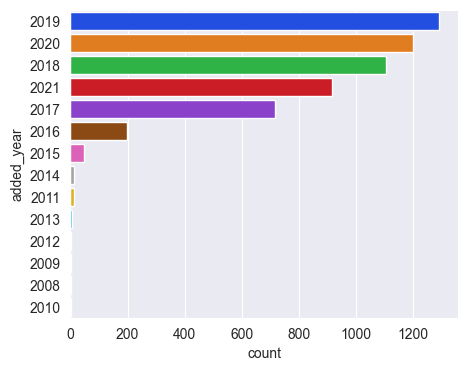

In [295]:
plt.figure(figsize=(5,4))
sns.countplot(data=movies,y='added_year',palette='bright',order=movies['added_year'].value_counts().index)

可以看得出來自從2017年在電影數量有明顯的增加，並且每一年都有明顯的成長，那2019年電影數量最多。
then what about TV shows?


#### 在哪一年的TVshows數目最多? largest influx of TV shows in which year?

不能跟電影一樣直接選年份，要先將日期為空值得先drop掉，再進行下一步。

In [304]:
shows.sample()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
4549,s4550,TV Show,Monty Python's Almost the Truth,NaN,"Graham Chapman, Eric Idle, John Cleese, Michae...",[United Kingdom],"October 2, 2018",2009,TV-MA,1 Season,"[British TV Shows, Docuseries]","The legacy of comedy group Monty Python, whose..."


In [299]:
shows.isnull().sum()


show_id            0
type               0
title              0
director        2446
cast             350
country            0
date_added        10
release_year       0
rating             2
duration           0
listed_in          0
description        0
dtype: int64

In [301]:
index = shows[shows['date_added'].isnull()].index
shows_1 = shows.drop(axis=0,index= index)

In [302]:
shows_1['added_years'] = shows_1['date_added'].apply(lambda x: x[-4:])
shows_1['added_years'].unique()

array(['2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014',
       '2013', '2008'], dtype=object)

In [305]:
shows_1['added_years'].value_counts()

added_years
2020    595
2019    592
2021    505
2018    412
2017    349
2016    176
2015     26
2014      5
2013      5
2008      1
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='added_years'>

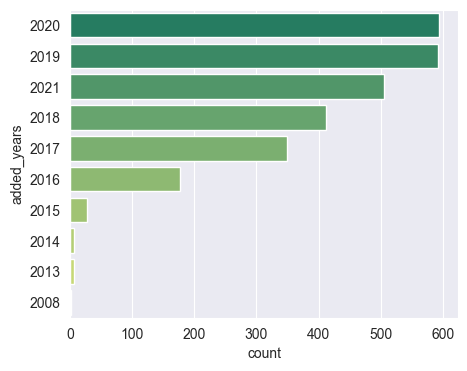

In [308]:
plt.figure(figsize=(5,4))
sns.countplot(data=shows_1,y='added_years',palette='summer',order=shows_1['added_years'].value_counts().index)

### 總結
Netflix 從2017年開始流行。節目跟電影開始充斥這個平台。<br>
